# 1D Burger's LaSDI-LS Example

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import product
import sys,time
import os
import pickle
sys.path.append("..") # Adds higher directory to python modules path.
from LaSDI import LaSDI
import matplotlib

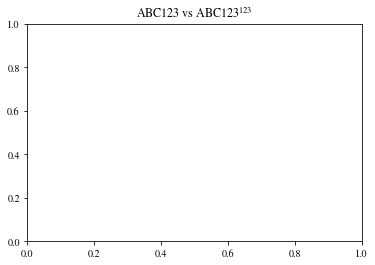

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['figure.dpi'] = 150

### Load necessary data from Build and Train files.

In [3]:
# ### Load Data if Model Already Exists ###
snapshot_full = pickle.load(open("./data/snapshot_git.p", 'rb'))
snapshot_full = snapshot_full[:,:-1].astype('float32')
snapshot_full_FOM = pickle.load(open("./data/FOM.p",'rb'))
FOM_time = snapshot_full_FOM['time']
snapshot_full_FOM = snapshot_full_FOM['FOM'][:,:-1].astype('float32')

/g/g15/fries4
/g/g15/fries4/SALDI/1DBurgers


### Perform SVD to find POD and import simulation parameters

In [4]:
u,s,vh = LA.svd(snapshot_full.T)
sv_mass = np.cumsum(s)
sv_count = 5# [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi = u[:,:sv_count]

nx = 1001
dx = 6 / (nx - 1)
nt = 1000
tstop = 1
x=np.linspace(-3, 3, nx)

dt = tstop / nt 
c = dt/dx
t = np.linspace(0, tstop, nt)

5 [0.8651298  0.94952995 0.9815408  0.99105346 0.9969581 ]


### Transform training data into latent-space trajectories

In [5]:
amp_arr = np.array([.75,.85])
width_arr = np.array([.95,1.05])
P = list(product(amp_arr, width_arr))
P = np.array(P)

ndata = snapshot_full.shape[0]
nset = int(ndata/(nt+1))

latent_space_LS_list = []

for foo in range(nset):
    latent_space_LS = np.matmul(phi.T, snapshot_full[foo*(nt+1):(foo+1)*(nt+1)].T).T
    latent_space_LS_list.append(latent_space_LS)

### Generate LaSDI-LS model

x0' = 0.007 1 + -0.002 x0 + -0.333 x1 + 0.006 x2 + 0.112 x3 + 0.216 x4
x1' = 4.414 1 + 0.648 x0 + 0.072 x1 + -0.768 x2 + 0.558 x3 + 0.156 x4
x2' = -0.223 1 + -0.024 x0 + 0.924 x1 + 0.073 x2 + -0.514 x3 + 0.040 x4
x3' = 0.110 1 + 0.007 x0 + -0.737 x1 + 0.078 x2 + 0.348 x3 + -1.787 x4
x4' = -0.174 1 + -0.026 x0 + 0.015 x1 + -0.773 x2 + 2.004 x3 + 0.457 x4


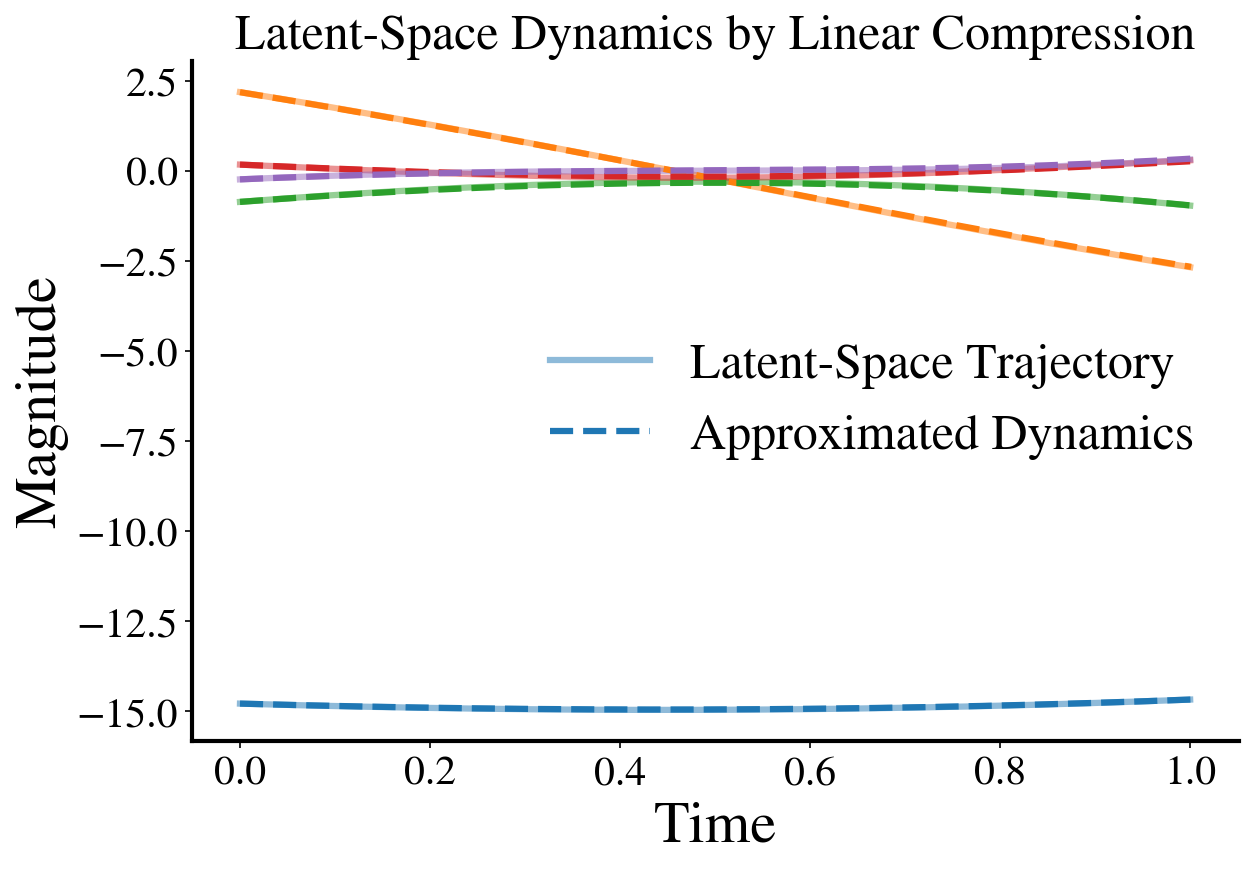

In [6]:
degree = 1
normal = 1
LaSDI_model = LaSDI(phi.T, phi)
LaSDI_model.train_dynamics(latent_space_LS_list, P, dt)

## Generate ROM and visualize results

Final Position Error: 0.487%


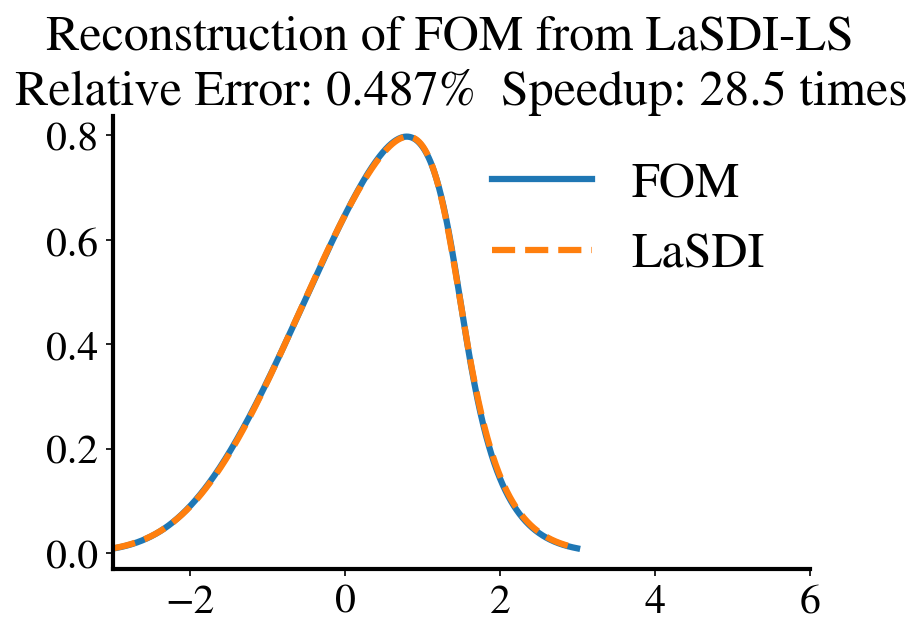

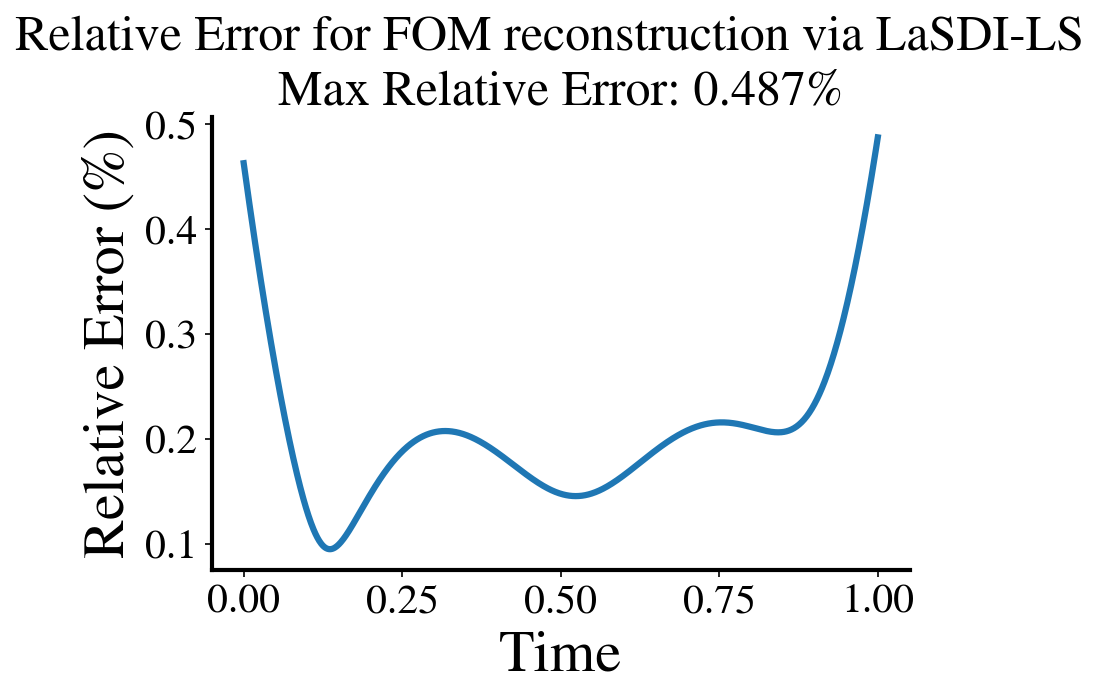

In [10]:
start = time.time()
FOM_recon = LaSDI_model.generate_ROM(snapshot_full_FOM[0], np.array([0.8,1.0]),t)
LaSDI_time = time.time()-start

print('Final Position Error: {:.3}%'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100))
fig = plt.figure()
ax = plt.axes()
fig.suptitle('Reconstruction of FOM from LaSDI-LS', y = 1.05)
ax.set_title('Relative Error: {:.3}%  Speedup: {:.3} times'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100, FOM_time/LaSDI_time))
ax.plot(x[:-1],snapshot_full_FOM[-1], label = 'FOM')
ax.plot(x[:-1], FOM_recon[-1],'--', label = 'LaSDI')
ax.legend()
ax.set_xlim(-3,6)


FOM_re = np.empty(nt)
for i in range(nt):
    FOM_re[i] = LA.norm(FOM_recon[i]-snapshot_full_FOM[i])/LA.norm(snapshot_full_FOM[i])

fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-LS', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(FOM_re)*100))
ax.plot(t, FOM_re*100)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
torch.cuda.empty_cache()